In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
url = 'https://docs.google.com/spreadsheets/d/1HcdISgCl3s4RpWkJa8m-G1JjfKzd8qf2WY2Xcw32D7U/pub?gid=1371955398&single=true&output=csv'

In [4]:
import pandas
import re
from enum import Enum

class Character(Enum):
   
    def __ge__(self, other):
        if self.__class__ is other.__class__:
            return self.value >= other.value
        return NotImplemented
    def __gt__(self, other):
        if self.__class__ is other.__class__:
            return self.value > other.value
        return NotImplemented
    def __le__(self, other):
        if self.__class__ is other.__class__:
            return self.value <= other.value
        return NotImplemented
    def __lt__(self, other):
        if self.__class__ is other.__class__:
            return self.value < other.value
        return NotImplemented

    Argagarg = 'argagarg'
    BBB = 'bbb'
    DeGrey = 'degrey'
    Geiger = 'geiger'
    Gloria = 'gloria'
    Grave = 'grave'
    Gwen = 'gwen'
    Jaina = 'jaina'
    Lum = 'lum'
    Menelker = 'menelker'
    Midori = 'midori'
    Onimaru = 'onimaru'
    Persephone = 'persephone'
    Quince = 'quince'
    Rook = 'rook'
    Setsuki = 'setsuki'
    Troq = 'troq'
    Valerie = 'valerie'
    Vendetta = 'vendetta'
    Zane = 'zane'
    
for char in Character:
    locals()[char.name] = char
    
historical_record = pandas.read_csv(url)
historical_record.columns = [re.sub('\W+', '_', col.lower()).strip('_') for col in historical_record.columns]

historical_record = historical_record[
    ~historical_record.character_1.isin(['Squall', 'Kefka', 'Ultimicia']) &
    ~historical_record.character_2.isin(['Squall', 'Kefka', 'Ultimicia'])
]

historical_record.character_2.replace(to_replace=['variable'], value=['Gloria'], inplace=True)

names = pandas.DataFrame({'name': historical_record.player_1.append(historical_record.player_2)})
names['lower'] = names.apply(lambda r: r['name'].lower(), axis=1)
name_map = names.groupby('lower').first()

historical_record['match_date'] = pandas.to_datetime(historical_record.match_date, infer_datetime_format=True)
historical_record.format_restricted.replace(to_replace=['.', 'Restricted'], value=[False, True], inplace=True)
historical_record.format_team.replace(to_replace=['.', 'Team'], value=[False, True], inplace=True)
historical_record.char_select_random.replace(to_replace=['.', 'Random'], value=[False, True], inplace=True)
historical_record.char_select_locked.replace(to_replace=['.', 'Locked'], value=[False, True], inplace=True)
historical_record.set_length_non_ft3_ft4.replace(to_replace=['.', 'non-FT3/FT4'], value=[False, True], inplace=True)
historical_record.set_win_1 = historical_record.set_win_1.fillna(0)
historical_record.set_win_2 = historical_record.set_win_2.fillna(0)
historical_record.wins_1 = historical_record.wins_1.fillna(0)
historical_record.wins_2 = historical_record.wins_2.fillna(0)
historical_record.character_1 = historical_record.character_1.apply(lambda n: Character(n.lower()))
historical_record.character_2 = historical_record.character_2.apply(lambda n: Character(n.lower()))
historical_record.player_1 = historical_record.player_1.apply(lambda n: name_map.loc[n.lower()])
historical_record.player_2 = historical_record.player_2.apply(lambda n: name_map.loc[n.lower()])


In [5]:
historical_record.head()

,tournament_name,match_date,char_select_random,char_select_locked,set_length_non_ft3_ft4,format_team,format_restricted,set_win_1,player_1,character_1,wins_1,wins_2,character_2,player_2,set_win_2
0,IYL Season 1,2014-08-16,False,False,False,False,False,0.0,Akawashi,Character.Gwen,2.0,1.0,Character.Argagarg,Bob199,1.0
1,IYL Season 1,2014-08-16,False,False,False,False,False,0.0,Akawashi,Character.Gwen,0.0,2.0,Character.Lum,Bob199,0.0
2,IYL Season 1,2014-08-17,False,False,False,False,False,0.0,CKR,Character.Setsuki,2.0,1.0,Character.Zane,Bob199,1.0
3,IYL Season 1,2014-08-17,False,False,False,False,False,0.0,CKR,Character.Setsuki,0.0,2.0,Character.Grave,Bob199,0.0
4,IYL Season 1,2014-08-17,False,False,False,False,False,1.0,Akawashi,Character.Troq,1.0,0.0,Character.Argagarg,CKR,0.0


In [6]:
import numpy as np
p1_wins = historical_record.loc[np.repeat(historical_record.index.values, historical_record.wins_1.astype(int))].reset_index(drop=True)
p2_wins = historical_record.loc[np.repeat(historical_record.index.values, historical_record.wins_2.astype(int))].reset_index(drop=True)

p1_wins['win'] = 1
p2_wins['win'] = 0

games = pandas.concat([p1_wins, p2_wins]).reset_index(drop=True)[['tournament_name', 'match_date', 'player_1', 'character_1', 'win', 'character_2', 'player_2']]

backwards_mus = games.character_1 > games.character_2
games[backwards_mus] = games[backwards_mus].rename(columns={
    'player_1': 'player_2',
    'player_2': 'player_1',
    'character_1': 'character_2',
    'character_2': 'character_1',
})
games.loc[backwards_mus, ['win']] = 1 - games[backwards_mus].win

mirror_mus_to_flip = list(games[games.character_1 == games.character_2].iloc[::2].index.values)
games.iloc[mirror_mus_to_flip] = games.iloc[mirror_mus_to_flip].rename(columns={
    'player_1': 'player_2',
    'player_2': 'player_1',
    'character_1': 'character_2',
    'character_2': 'character_1',
})
games.iloc[mirror_mus_to_flip, games.columns.get_loc('win')] = 1 - games.iloc[mirror_mus_to_flip].win

In [7]:
games[games.character_1 == games.character_2].win.sum()

637

In [8]:
games.head()

,tournament_name,match_date,player_1,character_1,win,character_2,player_2
0,IYL Season 1,2014-08-16,Bob199,Character.Argagarg,0,Character.Gwen,Akawashi
1,IYL Season 1,2014-08-16,Bob199,Character.Argagarg,0,Character.Gwen,Akawashi
2,IYL Season 1,2014-08-17,CKR,Character.Setsuki,1,Character.Zane,Bob199
3,IYL Season 1,2014-08-17,CKR,Character.Setsuki,1,Character.Zane,Bob199
4,IYL Season 1,2014-08-17,CKR,Character.Argagarg,0,Character.Troq,Akawashi


In [9]:
import pystan

stan_code = """
data {
    int<lower=0> NPT; // Number of player/tournaments
    int<lower=0> NG; // Number of games
    int<lower=0> NM; // Number of matchups
    int<lower=0, upper=1> win[NG]; // Did player 1 win game
    int<lower=1, upper=NPT> pt1[NG]; // Player/tournament 1 in game
    int<lower=1, upper=NPT> pt2[NG]; // Player/tournament 2 in game
    int<lower=1, upper=NM> mup[NG]; // Matchup in game
    int<lower=0, upper=NPT> prev_tournament[NPT]; // Previous tournament for player/tournament
}
parameters {
    vector[NPT] skill_adjust; // Skill change before player/tournament
    vector[NM] mu; // Matchup number
}
transformed parameters {
    vector[NPT] skill;
    
    for (t in 1:NPT) {
        if (prev_tournament[t] == 0)
            skill[t] = skill_adjust[t];
        else
            skill[t] = skill[prev_tournament[t]] + skill_adjust[t];
    }
    
}
model {
    skill_adjust ~ normal(0, 1);
    mu ~ normal(0, 1);
    win ~ bernoulli_logit(skill[pt1] - skill[pt2] + mu[mup]);
}
"""

model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0e6afa38bcec18ef6b02f12adfdb9bb9 NOW.
/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpphet7e_9/stanfit4anon_model_0e6afa38bcec18ef6b02f12adfdb9bb9_2983217538676975447.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [10]:
player_index = dict(zip(sorted(games.player_1.append(games.player_2).unique()), range(1, 1000)))
mu_index = dict(zip(((c1, c2) for c1 in Character for c2 in Character if c1 <= c2), range(1, 1000)))

p1_games = games[['player_1', 'tournament_name', 'match_date']].rename(columns={'player_1': 'player'})
p2_games = games[['player_2', 'tournament_name', 'match_date']].rename(columns={'player_2': 'player'})

player_tournament_dates = (
    p1_games
    .append(p2_games)
    .groupby(['player', 'tournament_name'])
    .match_date
    .quantile(0.5)
    .reset_index()
    .sort_values(['match_date', 'player'])
    .reset_index(drop=True)
)

player_tournament_index = dict(player_tournament_dates.apply(lambda r: ((r.player, r.tournament_name), r.name + 1), axis=1).values)

for player in player_tournament_dates.player.unique():
    player_tournament_dates.loc[player_tournament_dates.player == player, 'previous'] = (
        [-1] + list(player_tournament_dates.loc[player_tournament_dates.player == player].index.values)[:-1]
    )


ordered_tournaments = games.groupby('tournament_name').match_date.quantile(0.5).reset_index().sort_values('match_date').tournament_name
tournament_index = dict(zip(ordered_tournaments, range(1, 1000)))

stan_data = {
    'NPT': len(player_tournament_index),
    'NG': len(games),
    'NM': len(mu_index),
    'win': games.win,
    'pt1': games.apply(lambda r: player_tournament_index[(r.player_1, r.tournament_name)], axis=1),
    'pt2': games.apply(lambda r: player_tournament_index[(r.player_2, r.tournament_name)], axis=1),
    'mup': games.apply(lambda r: mu_index[(r.character_1, r.character_2)], axis=1),
    'prev_tournament': player_tournament_dates.previous.astype(int).apply(lambda x: x+1)
}

In [59]:
fit = model.sampling(
    data=stan_data,
    iter=3000,
    chains=4,
    n_jobs=2,
)

In [60]:
fit_results = fit.to_dataframe().rename(columns={
    'mu[{}]'.format(ix): "{.value}-{.value}".format(c1, c2) for ((c1, c2), ix) in mu_index.items()
})

In [84]:
import hashlib
import datetime

model_hash = hashlib.md5(stan_code.encode('utf-8'))
now = datetime.datetime.now()

fit.to_dataframe().to_csv(f"{model_hash.hexdigest()}-{now:%Y-%m-%d-%H:%M:%S}.csv")
with open(f"{model_hash.hexdigest()}-{now:%Y-%m-%d-%H:%M:%S}.stan", "w") as code_file:
    code_file.write(stan_code)

In [85]:
from plotnine import *
from pandas.api.types import CategoricalDtype
from IPython.core.display import display
import ipywidgets as widgets

df = fit_results[
    [column for column in fit_results.columns if column.startswith('skill[')]
].unstack().rename('skill').reset_index()

reverse_index = {value: key for (key, value) in player_tournament_index.items()}

df['player'] = df.level_0.apply(lambda x: reverse_index[int(x[6:-1])][0])
df['tournament'] = df.level_0.apply(lambda x: reverse_index[int(x[6:-1])][1])

player_list = df.groupby('player').skill.median().sort_values().index.tolist()
player_cat = CategoricalDtype(categories=player_list, ordered=True)
df['player'] = df['player'].astype(player_cat)

tournament_list = games.groupby('tournament_name').match_date.quantile(0.5).sort_values().index.tolist()
tournament_cat = CategoricalDtype(categories=tournament_list, ordered=True)
df['tournament'] = df['tournament'].astype(tournament_cat)

def display_player(player):
    tournaments_played = len(df[df.player==player].tournament.unique())

    plot = (
        ggplot(df[df.player==player], aes(x='tournament', y='skill'))
        + geom_violin()
        + theme(
            figure_size=(.2*tournaments_played, 1),
            axis_text_x=element_text(rotation=90),
        )
        + labs(title=player)
    )
    plot.save(f"{player}-skill.png")
    display(plot)

/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 2.6 x 1 in image.
  from_inches(height, units), units))
/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: vengefulpickle-skill.png
  warn('Filename: {}'.format(filename))


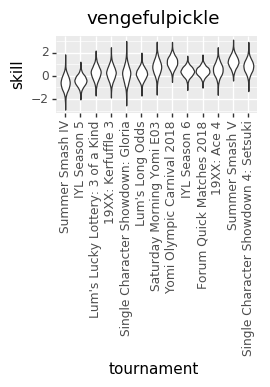

<ggplot: (8777545144759)>

In [86]:
display_player('vengefulpickle')

/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 9.600000000000001 x 1 in image.
  from_inches(height, units), units))
/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: mysticjuicer-skill.png
  warn('Filename: {}'.format(filename))


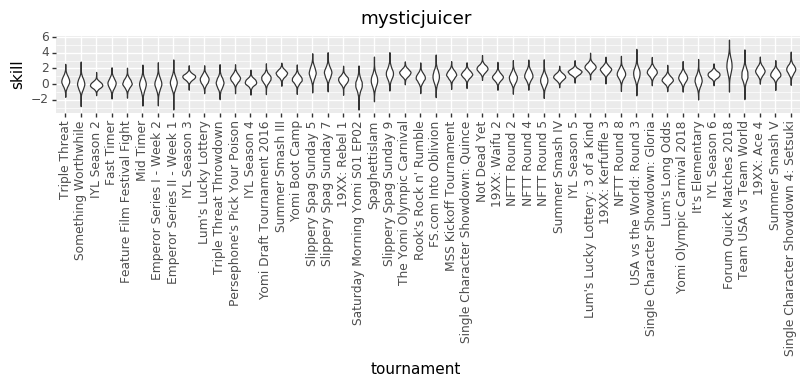

<ggplot: (8777512067157)>

In [87]:
display_player('mysticjuicer')

/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 2.4000000000000004 x 1 in image.
  from_inches(height, units), units))
/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: cpat-skill.png
  warn('Filename: {}'.format(filename))


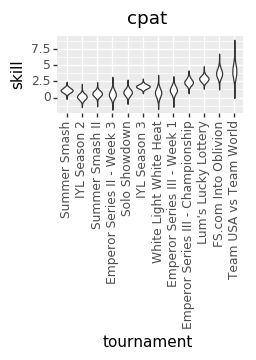

<ggplot: (-9223363259338149923)>

In [88]:
display_player('cpat')

/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 2.2 x 1 in image.
  from_inches(height, units), units))
/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: Hobusu-skill.png
  warn('Filename: {}'.format(filename))


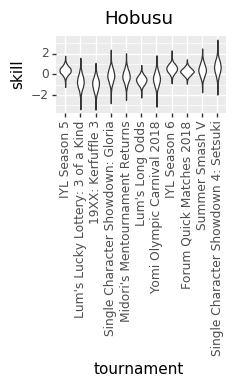

<ggplot: (-9223363259342882935)>

In [90]:
display_player('Hobusu')

/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.0 x 1 in image.
  from_inches(height, units), units))
/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: Fluffiness-skill.png
  warn('Filename: {}'.format(filename))


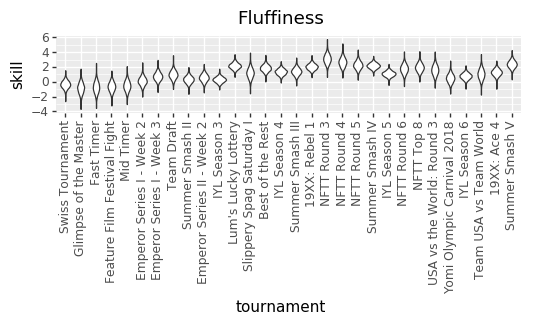

<ggplot: (8777511685615)>

In [91]:
display_player('Fluffiness')

/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 25 x 15 in image.
  from_inches(height, units), units))
/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: yomi-matchup-estimates.png
  warn('Filename: {}'.format(filename))
/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.i

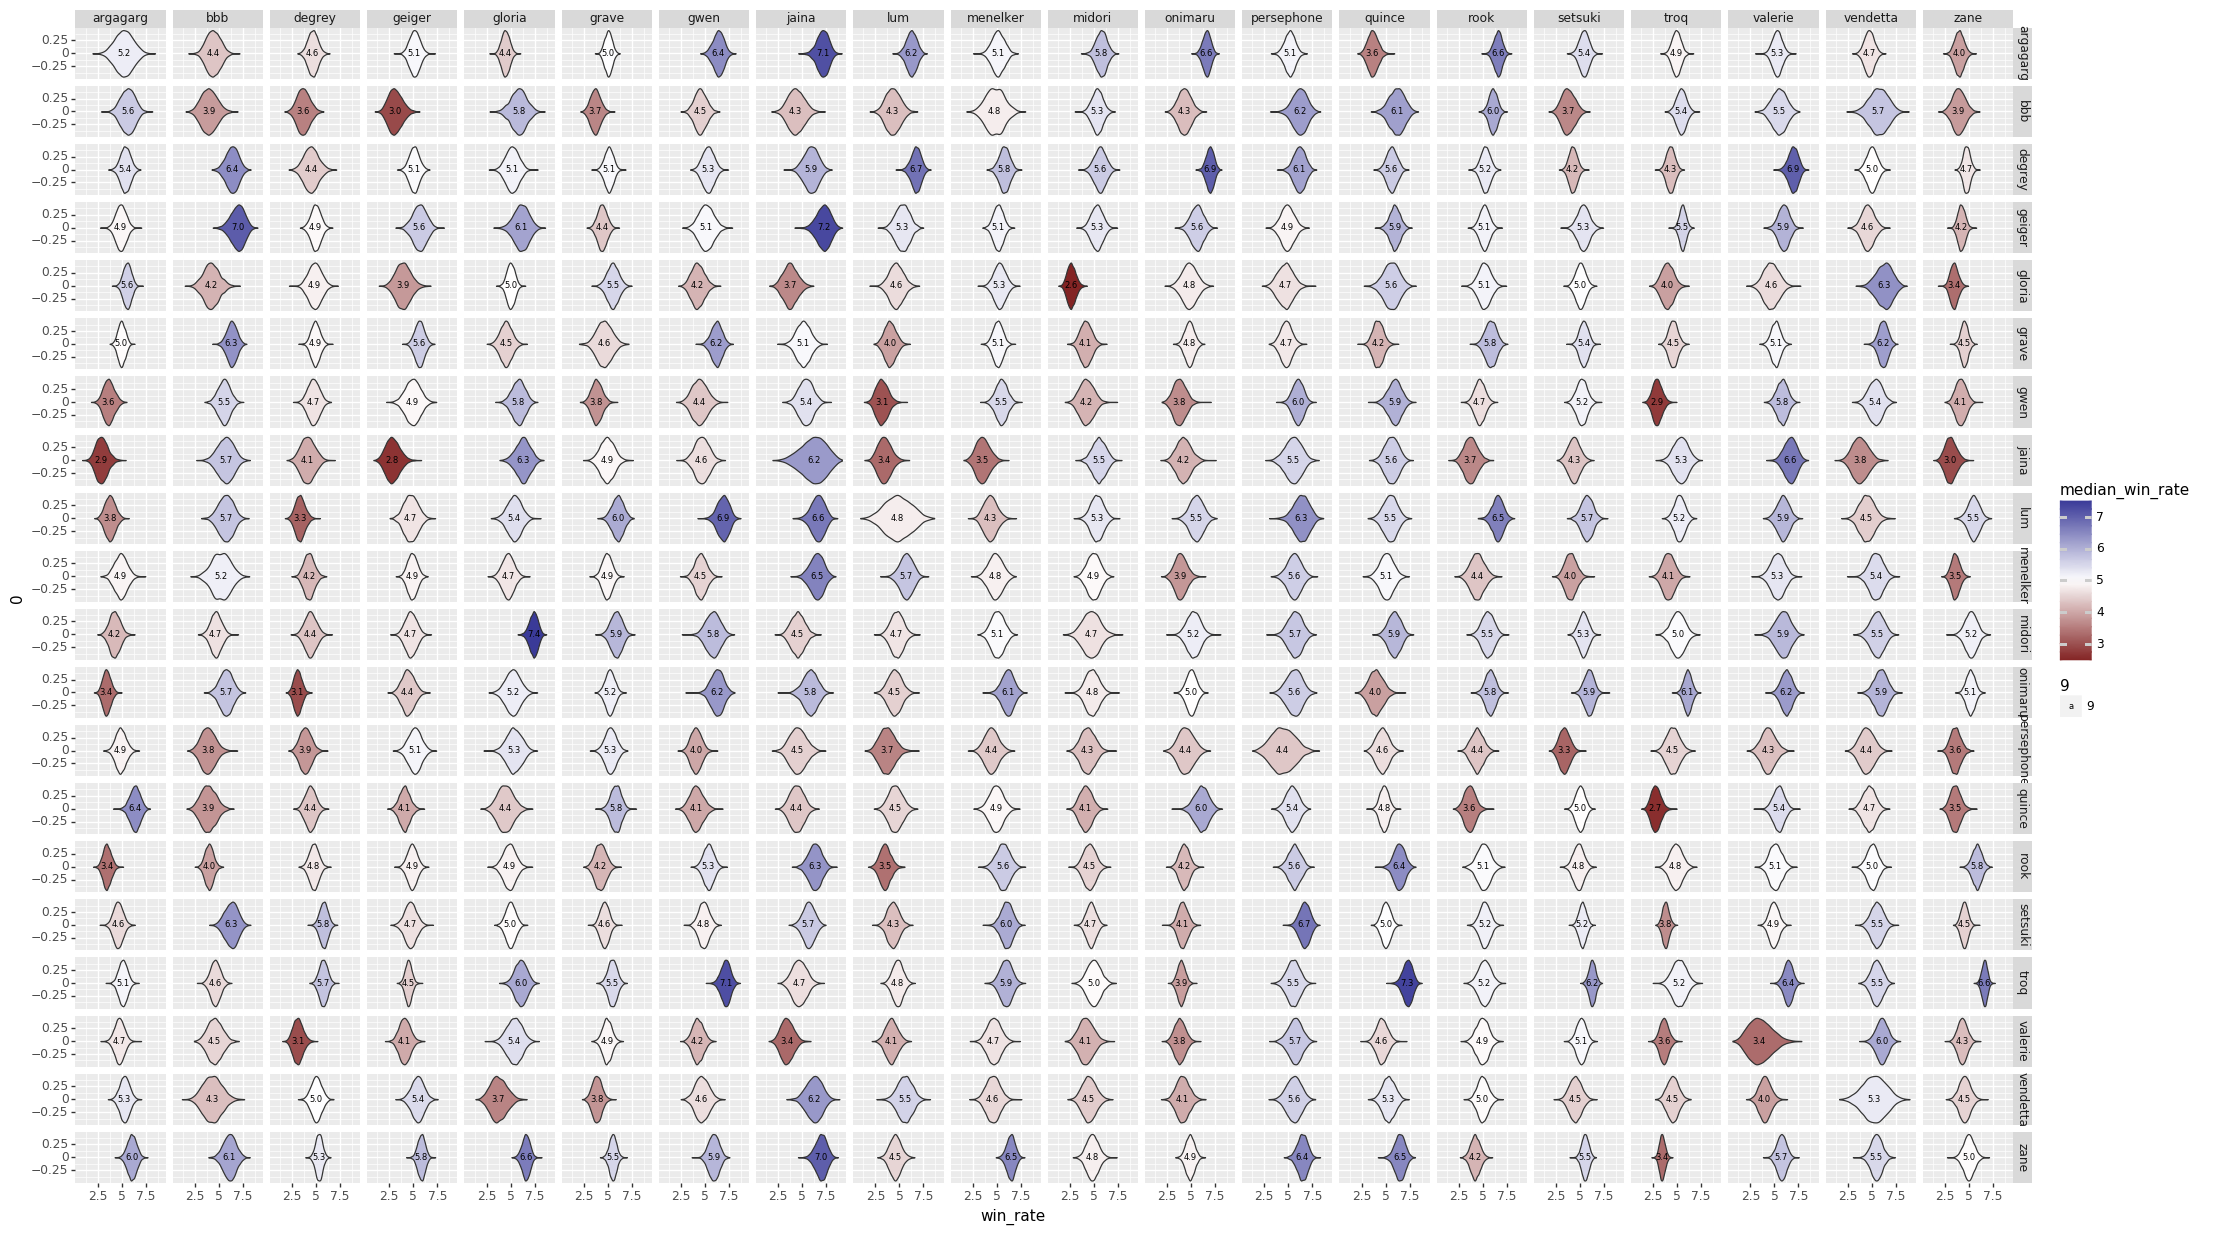

<ggplot: (8777537498509)>

In [80]:
from plotnine import *
import math

df2 = fit_results[["{.value}-{.value}".format(c1, c2) for (c1, c2) in mu_index.keys()]].unstack().rename('skill').reset_index()
df2['c1'] = df2.level_0.apply(lambda x: x.split('-')[0])
df2['c2'] = df2.level_0.apply(lambda x: x.split('-')[1])

flipped = df2[df2.c1 != df2.c2].rename(columns={'c1': 'c2', 'c2': 'c1'})
flipped['skill'] = -flipped['skill']

df2 = df2.append(flipped)

df2['win_rate'] = 10*(df2['skill'].rpow(math.e)) / (1 + df2['skill'].rpow(math.e))

median_rates = df2.groupby(['c1', 'c2']).win_rate.median().rename('median_win_rate')

df2 = df2.join(median_rates, on=['c1', 'c2'])
matchups = (
    ggplot(df2, aes(x='0', y='win_rate', fill='median_win_rate'))
    + geom_violin()
    + geom_text(
        data=median_rates.reset_index(),
        mapping=aes(label='median_win_rate', y='median_win_rate', x=0, size=9),
        format_string='{:.2}',
    )
    + facet_grid('c1 ~ c2')
    + coord_flip()
    + theme(figure_size=(25, 15))
    + scale_fill_gradient2(midpoint=5)
)

matchups.save('yomi-matchup-estimates.png')
matchups

In [99]:
iyl6 = df[df.tournament=='IYL Season 6'].copy()

iyl_player_list = iyl6.groupby('player').skill.median().sort_values().index.tolist()
iyl_player_cat = CategoricalDtype(categories=iyl_player_list, ordered=True)
iyl6['player'] = iyl6['player'].astype(iyl_player_cat)

plot = (
    ggplot(iyl6, aes(x='player', y='skill'))
    + geom_violin()
    + theme(
        figure_size=(10, 10),
    )
    + coord_flip()
)
plot.save('iyl6.png')

/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 10 x 10 in image.
  from_inches(height, units), units))
/home/cpennington/.virtualenvs/yomi-skill/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: iyl6.png
  warn('Filename: {}'.format(filename))
